# [Part 0] Energy Based Models

How can we estimate a probability distribution $p(\mathbf{x})$ across such a vast number of dimensions (for instance, the MNIST dataset images) using a basic neural network? The challenge lies in the fact that we cannot merely forecast a score between 0 and 1. A valid probability distribution over data must satisfy two fundamental properties:

1. The probability distribution must assign a non-negative value to every possible $\mathbf{x}$: $p(\mathbf{x}) \geq 0$.

2. The probability density must sum or integrate to 1 across the entire range of potential inputs: $\int_{\mathbf{x}} p(\mathbf{x}) d\mathbf{x} = 1$.

Fortunately, several methods exist to achieve this, one class of which are energy-based models. The core concept behind energy-based models is that any function that yields values greater than zero can be transformed into a probability distribution by normalizing it with respect to its volume. Consider a neural network with a single neuron in its output, akin to regression. We can denote this network as $f_{\theta}(\mathbf{x})$, with $\theta$ representing the network's parameters and $\mathbf{x}$ denoting the input data, such as an image. The output of $f_{\theta}$ is a scalar value ranging from $-\infty$ to $\infty$. Now, we can use basic probability theory to *normalize* the scores of all possible inputs:

$$
q_{\theta}(\mathbf{x}) = \frac{\exp\left(f_{\theta}(\mathbf{x})\right)}{Z_{\theta}} \hspace{5mm}\text{where}\hspace{5mm}
Z_{\theta} = \begin{cases}
    \int_{\mathbf{x}}\exp\left(f_{\theta}(\mathbf{x})\right) d\mathbf{x} & \text{if }x\text{ is continuous}\\
    \sum_{\mathbf{x}}\exp\left(f_{\theta}(\mathbf{x})\right) & \text{if }x\text{ is discrete}
\end{cases}
$$

The exponential function serves to guarantee that we attribute a probability greater than zero to all possible inputs. In some instances within the literature, an alternative notation is used: $f_{\theta}(\mathbf{x})$ is defined as $-E_{\theta}(\mathbf{x})$, with $E_{\theta}$ representing the energy function. In this convention, data points with a high likelihood are associated with lower energy values, while data points with a low likelihood are linked to higher energy values. The term $Z_{\theta}$ is our normalization factor, ensuring that the density integrates or sums up to 1. This can be demonstrated by performing an integral over $q_{\theta}(\mathbf{x})$:

$$
\int_{\mathbf{x}}q_{\theta}(\mathbf{x})d\mathbf{x} =
\int_{\mathbf{x}}\frac{\exp\left(f_{\theta}(\mathbf{x})\right)}{\int_{\mathbf{\tilde{x}}}\exp\left(f_{\theta}(\mathbf{\tilde{x}})\right) d\mathbf{\tilde{x}}}d\mathbf{x} =
\frac{\int_{\mathbf{x}}\exp\left(f_{\theta}(\mathbf{x})\right)d\mathbf{x}}{\int_{\mathbf{\tilde{x}}}\exp\left(f_{\theta}(\mathbf{\tilde{x}})\right) d\mathbf{\tilde{x}}} = 1
$$

The significant advantage of this probability distribution formulation lies in its adaptability, allowing us to define $f_{\theta}$ in any way we choose, free from constraints. Nevertheless, when we examine the equation above, a fundamental problem arises: How can we compute $Z_{\theta}$? It's practically impossible to analytically determine $Z_{\theta}$ when dealing with high-dimensional inputs and/or larger neural networks. However, it is imperative to have knowledge of $Z_{\theta}$ for the task at hand. This is where the concept of Contrastive Divergence comes into play.

### Contrastive Divergence

Generative models are typically trained using maximum likelihood estimation, where the goal is to maximize the likelihood of the instances within the training dataset. Since the precise likelihood of a data point can't be determined due to the unknown normalization constant  $Z_{\theta}$, training energy-based models requires a slightly different approach. It's not sufficient to merely maximize the unnormalized probability $\exp(f_{\theta}(\mathbf{x}_{\text{train}}))$ because there's no assurance that $Z{\theta}$ will remain constant or that $\mathbf{x}{\text{train}}$ will become more likely than other data points. However, by framing our training around a comparison of point likelihoods, we can establish a stable training objective. In other words, we can rephrase our maximum likelihood objective to focus on maximizing the probability of $\mathbf{x}_{\text{train}}$ in relation to a randomly selected data point from our model:

$$
\begin{split}
    \nabla_{\theta}\mathcal{L}_{\text{MLE}}(\mathbf{\theta};p) & = -\mathbb{E}_{p(\mathbf{x})}\left[\nabla_{\theta}\log q_{\theta}(\mathbf{x})\right]\\[5pt]
    & = \mathbb{E}_{p(\mathbf{x})}\left[\nabla_{\theta}f_{\theta}(\mathbf{x})\right] - \mathbb{E}_{q_{\theta}(\mathbf{x})}\left[\nabla_{\theta}f_{\theta}(\mathbf{x})\right]
\end{split}
$$

Given that the loss function is still the objective we want to optimize for, we seek to minimize the energy for data points obtained from the dataset while simultaneously maximizing the energy for data points randomly selected from our model (the sampling process will be elucidated later). While this objective may seem intuitively sound, the question arises: how is it derived from our initial distribution $q_{\theta}(\mathbf{x})$? The key lies in our approximation of $Z_{\theta}$ through a single Monte-Carlo sample. This approximation aligns precisely with the objective previously described.

We can get a better idea of how this objective works by revisiting the image we saw in class:

<center width="100%"><img src="imgs/contrastive_divergence.svg" width="700px"></center>

The point on the right, called "correct answer", represents a data point from the dataset (i.e. $x_{\text{train}}$), and the left point, "wrong answer", a sample from our model (i.e. $x_{\text{sample}}$).

# [Part 1] Import Libraries and Load Data

First, let's import our standard libraries below.

In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.4 MB/s eta 0:00:00


In [ ]:
## Standard libraries
import os
import json
import math
import numpy as np
import random

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial8"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

<ipython-input-2-02eaff2c9236>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cuda:0


We also have pre-trained models that we download below.

In [ ]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial8/"
# Files to download
pretrained_files = ["MNIST.ckpt", "tensorboards/events.out.tfevents.MNIST"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Image generation

As an example for energy-based models, we will train a model on image generation. Specifically, we will look at how we can generate MNIST digits with a very simple CNN model. However, it should be noted that energy models are not easy to train and often diverge if the hyperparameters are not well tuned. We will rely on training tricks proposed in the paper [Implicit Generation and Generalization in Energy-Based Models](https://arxiv.org/abs/1903.08689) by Yilun Du and Igor Mordatch ([blog](https://openai.com/blog/energy-based-models/)). The important part of this notebook is however to see how the theory above can actually be used in a model.

### Dataset

First, we can load the MNIST dataset below. Note that we need to normalize the images between -1 and 1 instead of mean 0 and std 1 because during sampling, we have to limit the input space. Scaling between -1 and 1 makes it easier to implement it.

In [ ]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=256, shuffle=False, drop_last=False, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 118411198.80it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 101453679.92it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40853056.62it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20053188.18it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# [Part 2] Model construction and training

### CNN Model

We will start by implementing our CNN model. Our model will apply several convolutions with stride 2 that downscale the images. If you are interested, you can also use a deeper model such as a small ResNet, but for simplicity, we suggest sticking with the tiny network.

The architecture is as follows:<pre>
    01. <b>Conv2D</b> layer          with <font color='blue'><b>16</b></font> filters of <font color='blue'><b>5x5</b></font> using stride <font color='blue'><b>2</b></font> and padding <font color='blue'><b>4</b></font>,
    02. <b>Swish</b> activation  
    03. <b>Conv2D</b> layer          with <font color='blue'><b>32</b></font> filters of <font color='blue'><b>3x3</b></font> using stride <font color='blue'><b>2</b></font> and padding <font color='blue'><b>1</b></font>,
    04. <b>Swish</b> activation  
    05. <b>Conv2D</b> layer          with <font color='blue'><b>64</b></font> filters of <font color='blue'><b>3x3</b></font> using stride <font color='blue'><b>2</b></font> and padding <font color='blue'><b>1</b></font>,
    06. <b>Swish</b> activation  
    07. <b>Conv2D</b> layer          with <font color='blue'><b>64</b></font> filters of <font color='blue'><b>3x3</b></font> using stride <font color='blue'><b>2</b></font> and padding <font color='blue'><b>1</b></font>,
    08. <b>Swish</b> activation  
    09. <b>Flatten</b> layer         to reshape activation into vector
    10. <b>Fully Connected</b>       with input size <font color='blue'><b>256</b></font> and output size <font color='blue'><b>64</b></font>,
    11. <b>Swish</b> activation  
    12. <b>Fully Connected</b>       with input size <font color='blue'><b>64</b></font> and output size <font color='blue'><b>1</b></font>,
</pre>

Note that the activation function will be Swish instead of the standard ReLU in our energy model.

#### <font color='red'>**YOUR CODE HERE:** </font>

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class CNNModel(nn.Module):
    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()

        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
            # Conv2D layer with 16 filters of 5x5 using stride 2 and padding 4
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2, padding=4),

            # Swish activation
            Swish(),

            # Conv2D layer with 32 filters of 3x3 using stride 2 and padding 1
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),

            # Swish activation
            Swish(),

            # Conv2D layer with 64 filters of 3x3 using stride 2 and padding 1
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),

            # Swish activation
            Swish(),

            # Conv2D layer with 64 filters of 3x3 using stride 2 and padding 1
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),

            # Swish activation
            Swish(),

            # Flatten layer to reshape activation into vector
            nn.Flatten(),

            # Fully Connected with input size 256 and output size 64
            nn.Linear(in_features=256, out_features=64),

            # Swish activation
            Swish(),

            # Fully Connected with input size 64 and output size 1
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x


In the rest of the notebook, the output of the model will represent $f_{\theta}(\mathbf{x})$ (or equivalently, $-E_{\theta}(\mathbf{x})$).

### Sampling from Energy-Based Models

A commonly used method for generating samples from an energy-based model involves using Markov Chain Monte Carlo with Langevin Dynamics. The basic premise of this algorithm is to start the process from a random point and gradually move in the direction of higher probability by using the gradients of $f_{\theta}$. Nonetheless, this approach alone is insufficient for fully capturing the probability distribution. To achieve this, we must introduce some noise, denoted as $\omega$, at each gradient step while moving through the current sample. Performing an infinite number of gradient steps would allow us to generate an exact sample from our modeled distribution. However, since this is not practically feasible, we often constrain the chain to a finite number of steps, denoted as $K$ (a hyperparameter that requires fine-tuning). The overall sampling process can be summarized through the following algorithm:

<center width="100%" style="padding:15px"><img src="imgs/sampling.svg" width="750px"></center>

### Sampling buffer

In the following section, we delve into the training process with sampled elements. To use the contrastive divergence objective, we must generate samples during training. Previous research has demonstrated that, due to the high dimensionality of images, a considerable number of iterations within the Markov Chain Monte Carlo (MCMC) sampling is necessary to obtain reasonable samples. However, there's a training technique that significantly reduces the cost of sampling: the use of a sampling buffer. The concept behind this is to retain the samples from the most recent few batches in a buffer and utilize them as the starting point for the MCMC algorithm in subsequent batches. This reduction in the sampling cost is attributed to the model requiring fewer steps to converge to acceptable samples. To ensure that we don't solely rely on previous samples and allow for the introduction of new samples, we initialize 5% of our samples from scratch, involving random noise values ranging between -1 and 1.

Here, we implement the sampling buffer. The function `sample_new_exmps` generates a fresh batch of "fake" images, so named because they have been generated but are not actually part of the dataset. As mentioned previously, 5% of these are initialized randomly, while the remaining 95% are selected at random from our buffer. In this initial batch, we conduct MCMC for 60 iterations to enhance image quality and bring the samples closer to those derived from $q_{\theta}(\mathbf{x})$. In the `generate_samples` function, you will implement the MCMC process for images. The hyperparameters such as `step_size`, `steps`, and the noise standard deviation $\sigma$ have been specifically configured for the MNIST dataset.

#### <font color='red'>**YOUR CODE HERE:** </font>

In [ ]:
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # Perform MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model.
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)

        # List for storing generations at each step (for later analysis)
        imgs_per_step = []

        ######### YOUR CODE HERE ##########
        # Langevin MCMC loop
        for _ in range(steps):
            # Part 1: Add noise to the input.
            # use the normal_() method on the noise buffer to sample noise with mean=0 and std =0.005
            noise.normal_(0, 0.005)
            # use the add_() method on inp_imgs.data to add the newly sampled noise.data
            inp_imgs.data.add_(noise.data)
            # use the clamp_() method on inp_imgs.data to clip the results to the interval [-1,1]
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: Calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

            # Part 3: Apply gradients to our current samples
            # use the add_() method on inp_imgs.data to add the calculated gradient (inp_imgs.grad.data)
            # multiplied by -step_size (note the negative sign since we are moving in the
            # negative gradient direction)
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            # use the clamp_() method on inp_imgs.data to clip the results to the interval [-1,1]
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())
        ####################################

        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

### Training algorithm

With the sampling buffer ready, we can complete our training algorithm. Below is a summary of the full training algorithm of an energy model for image modeling:

<center width="100%" style="padding: 15px"><img src="imgs/training_algorithm.svg" width="700px"></center>

In each training iteration, the initial steps correspond to the acquisition of real and synthetic data, as we've discussed regarding the sample buffer. We then compute the contrastive divergence objective using our energy model $f_{\theta}(x)=-E_{\theta}(x)$. However, there's an additional training technique we will use, which involves introducing a regularization loss on the output of $f_{\theta}$. Given that the regularization loss is of lesser importance compared to the contrastive divergence, we introduce a weight factor $\alpha$, which is typically considerably smaller than 1. *You need to implement both the contrastive divergence as well as the regularization loss, and combine them into the full loss term.* Finally, we execute an update step using an optimizer on the combined loss and add the newly generated samples to the buffer.

Below, we put this training dynamic into a PyTorch Lightning module.

#### <font color='red'>**YOUR CODE HERE:** </font>

In [ ]:
class DeepEnergyModel(pl.LightningModule):

    def __init__(self, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0, **CNN_args):
        super().__init__()
        self.save_hyperparameters()

        self.cnn = CNNModel(**CNN_args)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)
        self.example_input_array = torch.zeros(1, *img_shape)

    def forward(self, x):
        z = self.cnn(x)
        return z

    def configure_optimizers(self):
        # Energy models can have issues with momentum as the loss surfaces changes with its parameters.
        # Hence, we set it to 0 by default.
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97) # Exponential decay over epochs
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # We add minimal noise to the original images to prevent the model from focusing on purely "clean" inputs
        real_imgs, _ = batch
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)

        # Obtain samples
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)

        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        ######### YOUR CODE HERE ##########
        # Calculate losses
        # calculate the regularization loss as the mean of the sum of squares of real_out and fake_out
        # (remember you can use the built-in method mean() in any tensor, i.e. (a+b).mean() would give
        # the mean of the sum of tensors a and b)
        reg_loss = self.hparams.alpha * (real_out**2 + fake_out**2).mean()
        # calculate the contrastive divergence loss as the difference between the means of fake_out and real_out
        cdiv_loss = fake_out.mean() - real_out.mean()
        # calculate the full loss as cdiv + alpha*reg (note alpha is stored in self.hparams.alpha)
        loss = reg_loss + cdiv_loss
        ####################################

        # Logging
        self.log('loss', loss)
        self.log('loss_regularization', reg_loss)
        self.log('loss_contrastive_divergence', cdiv_loss)
        self.log('metrics_avg_real', real_out.mean())
        self.log('metrics_avg_fake', fake_out.mean())
        return loss

    def validation_step(self, batch, batch_idx):
        # For validating, we calculate the contrastive divergence between purely random images and unseen examples
        # Note that the validation/test step of energy-based models depends on what we are interested in the model
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1

        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        cdiv = fake_out.mean() - real_out.mean()
        self.log('val_contrastive_divergence', cdiv)
        self.log('val_fake_out', fake_out.mean())
        self.log('val_real_out', real_out.mean())

We do not include a formal test step because energy-based generative models typically do not undergo evaluation with a dedicated test set. Nevertheless, the validation step serves the purpose of providing insights into the difference between the energy or likelihood of random images and previously unseen examples from the dataset. Alternative testing methods could involve the generation of new images and evaluating their feasibility using metrics like FID or Inception score, or attempting to remove noise from images.

### Callbacks

To monitor our model's performance throughout the training process, we'll extensively utilize PyTorch Lightning's callback framework. It's worth noting that callbacks enable the execution of small functions at various points during training, often after completing an epoch. In this context, we have developed three distinct callbacks ourselves.

If you want to see the progress of the loss terms as well as the generative quality of the model across the training process you can launch tensorboard and look at the stored logs after training. The initial callback, called `GenerateCallback`, is used to incorporate image generations into the model's training process. After every $N$ epochs (typically, $N=5$ to reduce the output to TensorBoard), we select a small batch of random images and conduct numerous MCMC iterations until the model's image generation reaches a stable state. In contrast to the training, where 60 iterations were used, we perform 256 iterations here. This higher number is chosen because (1) we only need to perform it once as opposed to the training, which does it every iteration, and (2) we initiate the process from scratch rather than using a buffer. The implementation is as follows:

In [ ]:
class GenerateCallback(pl.Callback):

    def __init__(self, batch_size=8, vis_steps=8, num_steps=256, every_n_epochs=5):
        super().__init__()
        self.batch_size = batch_size         # Number of images to generate
        self.vis_steps = vis_steps           # Number of steps within generation to visualize
        self.num_steps = num_steps           # Number of steps to take during generation
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_epoch_end(self, trainer, pl_module):
        # Skip for all other epochs
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Generate images
            imgs_per_step = self.generate_imgs(pl_module)
            # Plot and add to tensorboard
            for i in range(imgs_per_step.shape[1]):
                step_size = self.num_steps // self.vis_steps
                imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
                grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1))
                trainer.logger.experiment.add_image(f"generation_{i}", grid, global_step=trainer.current_epoch)

    def generate_imgs(self, pl_module):
        pl_module.eval()
        start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
        start_imgs = start_imgs * 2 - 1
        torch.set_grad_enabled(True)  # Tracking gradients for sampling necessary
        imgs_per_step = Sampler.generate_samples(pl_module.cnn, start_imgs, steps=self.num_steps, step_size=10, return_img_per_step=True)
        torch.set_grad_enabled(False)
        pl_module.train()
        return imgs_per_step

The next callback, named `SamplerCallback`, essentially involves selecting a randomly chosen subset of images from the sampling buffer and displaying them on TensorBoard. This process aids in gaining insight into the specific images being presented to the model as "fake" during the training.

In [ ]:
class SamplerCallback(pl.Callback):

    def __init__(self, num_imgs=32, every_n_epochs=5):
        super().__init__()
        self.num_imgs = num_imgs             # Number of images to plot
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            exmp_imgs = torch.cat(random.choices(pl_module.sampler.examples, k=self.num_imgs), dim=0)
            grid = torchvision.utils.make_grid(exmp_imgs, nrow=4, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("sampler", grid, global_step=trainer.current_epoch)

Lastly, we have the `OutlierCallback`. This callback assesses the model's performance by logging the negative energy values assigned to random noise. Unlike our training loss, which remains relatively stable throughout iterations, this score likely indicates the model's progress in identifying "outliers."

In [ ]:
class OutlierCallback(pl.Callback):

    def __init__(self, batch_size=1024):
        super().__init__()
        self.batch_size = batch_size

    def on_epoch_end(self, trainer, pl_module):
        with torch.no_grad():
            pl_module.eval()
            rand_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
            rand_imgs = rand_imgs * 2 - 1.0
            rand_out = pl_module.cnn(rand_imgs).mean()
            pl_module.train()

        trainer.logger.experiment.add_scalar("rand_out", rand_out, global_step=trainer.current_epoch)

### Running the model

We can now assemble all the components to construct our training function. This function closely resembles other PyTorch Lightning training functions we've encountered. Nevertheless, there is a slight deviation in that we do not conduct testing on a dedicated test set. The model's evaluation will be carried out afterward by assessing its predictions and its capacity for outlier detection.

In [ ]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "MNIST"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=60,
                         gradient_clip_val=0.1,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor='val_contrastive_divergence'),
                                    GenerateCallback(every_n_epochs=5),
                                    SamplerCallback(every_n_epochs=5),
                                    OutlierCallback(),
                                    LearningRateMonitor("epoch")
                                   ])
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = DeepEnergyModel(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DeepEnergyModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # No testing as we are more interested in other properties
    return model

In [ ]:
model = train_model(img_shape=(1,28,28),
                    batch_size=train_loader.batch_size,
                    lr=1e-4,
                    beta1=0.0)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Found pretrained model, loading...


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.1.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial8/MNIST.ckpt`


# [Part 3] Analysis


In this last part of this notebook, we will try to analyze the properties of our trained generative model.

### Image Generation

A standard approach for assessing generative models involves generating a handful of sample images. The proficiency of these models is truly demonstrated when they can effectively produce realistic images, showcasing their ability to model the actual data distribution. Therefore, let's generate a few images from the model and display them below:

In [ ]:
model.to(device)
pl.seed_everything(43)
callback = GenerateCallback(batch_size=4, vis_steps=8, num_steps=256)
imgs_per_step = callback.generate_imgs(model)
imgs_per_step = imgs_per_step.cpu()

INFO:lightning_fabric.utilities.seed:Seed set to 43


We know that sampling from energy-based models requires iteratively using the MCMC algorithm. To gain more insight into how this process affects the images, let's plot a few intermediate MCMC samples:

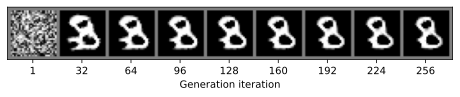

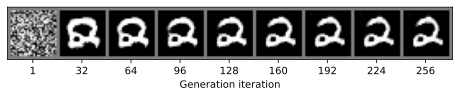

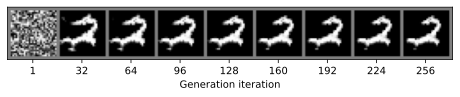

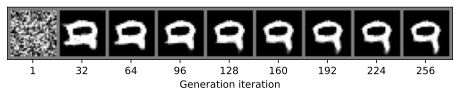

In [ ]:
for i in range(imgs_per_step.shape[1]):
    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
    imgs_to_plot = torch.cat([imgs_per_step[0:1,i],imgs_to_plot], dim=0)

    # Normalize the image tensors to the range (-1, 1)
    imgs_to_plot_normalized = (imgs_to_plot + 1) / 2

    grid = torchvision.utils.make_grid(imgs_to_plot_normalized, nrow=imgs_to_plot.shape[0], pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks([(imgs_per_step.shape[-1] + 2) * (0.5 + j) for j in range(callback.vis_steps + 1)],
               labels=[1] + list(range(step_size, imgs_per_step.shape[0] + 1, step_size)))
    plt.yticks([])
    plt.show()


### Out-of-distribution detection

A widely used and robust application of energy-based models is the task of out-of-distribution detection, sometimes referred to as "anomaly" detection. In an era where deep learning models find increasing utility in production and various applications, it becomes imperative to understand the boundaries of what these models are unfamiliar with. Deep learning models, by nature, tend to be overly confident, often assigning high probabilities to even random images, which is clearly undesirable in practical applications. Energy-based models offer a solution to this challenge because they are specifically trained to identify images that deviate from the distribution of the training dataset. In practical scenarios, you could train an energy-based model alongside a classifier and only rely on the classifier's predictions if the energy-based model assigns an (unnormalized) probability greater than a certain threshold, denoted as $\delta$, to the image. In fact, you can integrate classifier and energy-based objectives into a single model, as proposed in this [paper](https://arxiv.org/abs/1912.03263).

In this section, we will assess our energy-based model's ability to detect out-of-distribution data. It's important to bear in mind that a lower model output corresponds to a lower probability. Therefore, we anticipate observing low scores when we input random noise into the model:

In [ ]:
with torch.no_grad():
    rand_imgs = torch.rand((128,) + model.hparams.img_shape).to(model.device)
    rand_imgs = rand_imgs * 2 - 1.0
    rand_out = model.cnn(rand_imgs).mean()
    print(f"Average score for random images: {rand_out.item():4.2f}")

Average score for random images: -17.88


In [ ]:
with torch.no_grad():
    train_imgs,_ = next(iter(train_loader))
    train_imgs = train_imgs.to(model.device)
    train_out = model.cnn(train_imgs).mean()
    print(f"Average score for training images: {train_out.item():4.2f}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Average score for training images: -0.01


What happens if we change the training images a little, and see which ones gets a very low score?

In [ ]:
@torch.no_grad()
def compare_images(img1, img2):
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    score1, score2 = model.cnn(imgs).cpu().chunk(2, dim=0)

    # Normalize the image tensors to the range (-1, 1)
    img1_normalized = (img1 + 1) / 2  # Assuming original range is [0, 1]
    img2_normalized = (img2 + 1) / 2

    # Create the grid with normalized images
    grid = torchvision.utils.make_grid(
        [img1_normalized.cpu(), img2_normalized.cpu()], nrow=2, pad_value=0.5, padding=2
    )

    # Permute and display the grid as before
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4, 4))
    plt.imshow(grid)
    plt.xticks([(img1.shape[2] + 2) * (0.5 + j) for j in range(2)], labels=["Original image", "Transformed image"])
    plt.yticks([])
    plt.show()

    print("Score original image: %4.2f" % score1)
    print("Score transformed image: %4.2f" % score2)


We use a random test image for this. Feel free to change it to experiment with the model yourself

In [ ]:
test_imgs, _ = next(iter(test_loader))
exmp_img = test_imgs[0].to(model.device)

#### <font color='red'>**YOUR CODE HERE:** </font>
The first transformation is to add some random noise to the image:

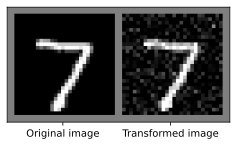

Score original image: 0.03
Score transformed image: -0.07


In [ ]:
# add gaussian noise (0 mean, 0.3 variancve) to exmp_img by using torch.randn_like()
# note you can modify the variance by multiplying the noise term by the desired variance
img_noisy = exmp_img + torch.randn_like(exmp_img) * 0.3
# clamp the resulting noisy image so the values are within the range [-1,1]
img_noisy.clamp_(min=-1.0, max=1.0)

compare_images(exmp_img, img_noisy)



#### <font color='red'>**YOUR CODE HERE:** </font>
Next, we flip an image and check how this influences the score:

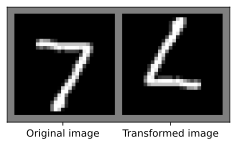

Score original image: 0.03
Score transformed image: -0.00


In [ ]:
# flip exmp_image along both dimensions using the flip() method
img_flipped = exmp_img.flip(dims=(1, 2))
compare_images(exmp_img, img_flipped)

Finally, we check what happens if we reduce the digit significantly in size:

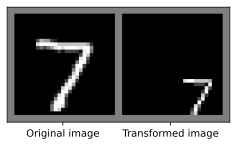

Score original image: 0.03
Score transformed image: -0.02


In [ ]:
img_tiny = torch.zeros_like(exmp_img)-1
img_tiny[:,exmp_img.shape[1]//2:,exmp_img.shape[2]//2:] = exmp_img[:,::2,::2]
compare_images(exmp_img, img_tiny)

Do you think the model is good at detecting differences between original and transformed images?